In [1]:
import transformers
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import torch
from torchvision import transforms
from IPython.display import Image as Img
from PIL import Image
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from image_dataset import ImageDataSet #, collate_fn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# define scraping labels based off of the possible classes
label_names = ['dark', 'somber', 'gloomy', 'dark art', 'dark landscape', 'gloomy art', 
               'whimsical', 'colorful art', 'fantasy world', 'happy fantasy world', 'bright picture', 'whimsical music', 'bright art', 'bright landscape',
               'electronic music', 'retro', 'synthwave', 'techno party', 'night club', 'techno wallpaper', 'disco',
               'calm', 'peaceful', 'placid', 'calm water', 'peaceful art', 'peaceful landscape', 'calm art', 'serene',
               'founding fathers', 'classical', 'old timey art', 'vintage', 'cathedral', 'old england dainty', 'classical art']

data_transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.RandomAdjustSharpness(1.2, 0.2),
                                 transforms.RandomAutocontrast(0.2),
                                 transforms.RandomHorizontalFlip(0.25),
                                 transforms.ToPILImage()])

data_dir = './data/'

image_data = ImageDataSet(data_dir, label_names, data_transforms)
labels, counts = image_data.print_label_dist()
labels, counts = labels, counts
print("Total numer of images in the dataset:", len(image_data))

# print("\nLabel distribution:")
# for i in range(len(labels)):
#     print(str(labels[i]) + ':', counts[i])

Supported files: ['.png', '.jpg', '.jpeg']
Total numer of images in the dataset: 1158


In [4]:
# # visualize the data
# for folder in sorted(os.listdir(data_dir)):
#     rand_file = random.choice(os.listdir(data_dir + folder + '/'))
#     ext = os.path.splitext(rand_file)[1]
#     im_file = data_dir + folder + '/' + rand_file
#     im = Image.open(im_file)
#     width, height = im.size
    
#     print("Class label:", folder, "Size:", width,height)
#     display(Img(filename=im_file))

In [5]:
model_name = 'google/vit-base-patch16-224-in21k'
id2label = {str(i): c for i, c in enumerate(label_names)}
label2id = {c: str(i) for i, c in enumerate(label_names)}

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name,
                                                  num_labels=len(label_names),
                                                  id2label=id2label,
                                                  label2id=label2id).to(device)

/opt/conda/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model ch

In [6]:
# define function to prepare dataset for huggingface implementation
def transform(batch):
    inputs = feature_extractor([x for x in batch['image']], return_tensors='pt')
    inputs['labels'] = batch['label']
    return inputs

In [7]:
# define fine-tuning hyper parameters
epochs = 8
batch_size = 16
output_dir = './vit'
lr = 2e-4
train_split = 0.85

In [8]:
# train test split the data
train_size = int(train_split * len(image_data))
test_size = len(image_data) - train_size
    
train_data, eval_data = torch.utils.data.random_split(image_data, [train_size, test_size])

In [9]:
# convert from pytorch dataset to huggingface
def gen_train():
    for idx in range(len(train_data)):
        img, label = train_data[idx]
        yield {'image':img, 'label':label}
        
def gen_eval():
    for idx in range(len(eval_data)):
        img, label = eval_data[idx]
        yield {'image':img, 'label':label}

In [10]:
train_ds =  Dataset.from_generator(gen_train)
eval_ds = Dataset.from_generator(gen_eval)

prepared_train = train_ds.with_transform(transform)
prepared_eval = eval_ds.with_transform(transform)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /home/ref2156/.cache/huggingface/datasets/generator/default-0f76f1cb5c45f5e1/0.0.0. Subsequent calls will reuse this data.


Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /home/ref2156/.cache/huggingface/datasets/generator/default-e016b910a83785a6/0.0.0. Subsequent calls will reuse this data.


In [11]:
# define a function to compute the metrics during train/eval
top_k = 5
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argsort(-predictions)[:,0:top_k]
    top_k_acc = sum([l in p for l, p in zip(labels, preds)])/len(labels)
    return {'top_k_acc': top_k_acc}

def collate_fn(batch):
    return {'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.tensor([x['labels'] for x in batch])}

In [12]:
training_args = TrainingArguments(output_dir=output_dir,
                                  per_device_train_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  num_train_epochs=epochs,
                                  fp16=True,
                                  save_steps=100,
                                  eval_steps=100,
                                  logging_steps=10,
                                  learning_rate=lr,
                                  save_total_limit=2,
                                  remove_unused_columns=False,
                                  push_to_hub=False,
                                  load_best_model_at_end=True)

trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=prepared_train,
                  eval_dataset=prepared_eval,
                  tokenizer=feature_extractor)

In [13]:
# train the ViT
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Top K Acc
1,2.613700,2.514351,0.908046
2,1.807200,1.917032,0.925287
3,1.132000,1.509688,0.948276
4,0.628300,1.366572,0.954023
5,0.372600,1.395450,0.959770
6,0.222800,1.276479,0.954023
7,0.195900,1.276257,0.959770
8,0.135400,1.285129,0.959770


***** train metrics *****
  epoch                    =         8.0
  total_flos               = 568295673GF
  train_loss               =      1.0017
  train_runtime            =  0:03:55.04
  train_samples_per_second =      33.492
  train_steps_per_second   =        2.11


In [14]:
# evaluate the fine-tuning
metrics = trainer.evaluate(prepared_eval)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        8.0
  eval_loss               =     1.2763
  eval_runtime            = 0:00:02.92
  eval_samples_per_second =     59.527
  eval_steps_per_second   =      7.526
  eval_top_k_acc          =     0.9598


['gloomy', 'dark landscape', 'gloomy art', 'dark', 'peaceful landscape']


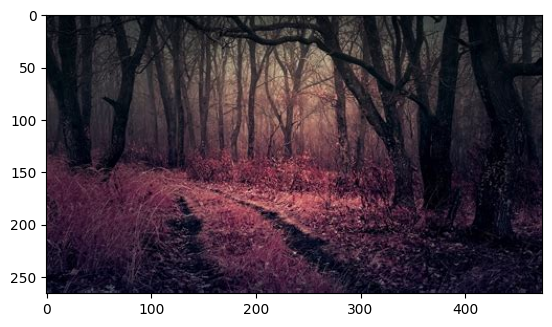

['retro', 'synthwave', 'peaceful art', 'disco', 'calm']


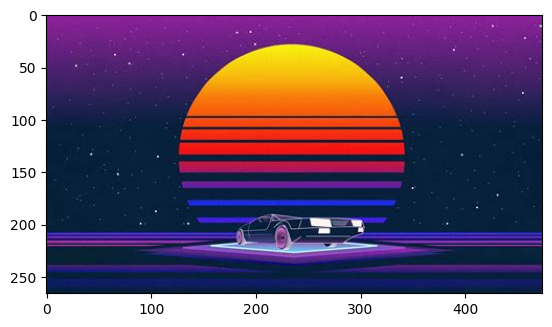

['fantasy world', 'happy fantasy world', 'bright landscape', 'calm art', 'bright picture']


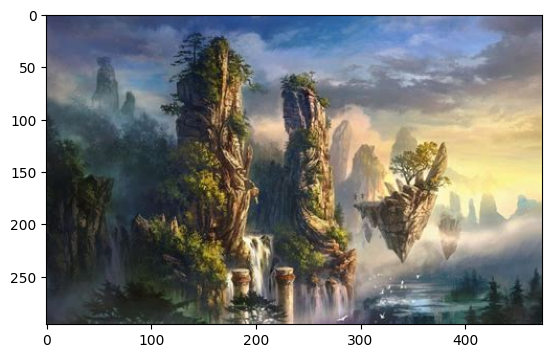

['retro', 'synthwave', 'electronic music', 'peaceful art', 'disco']


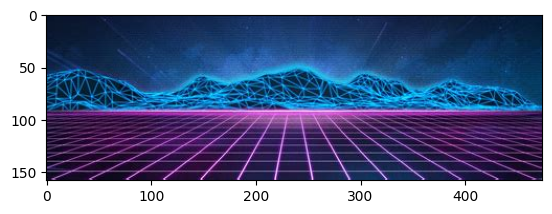

['bright art', 'colorful art', 'peaceful art', 'techno party', 'disco']


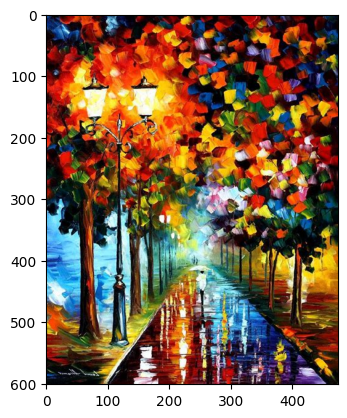

In [15]:
to_tensor = transforms.ToTensor()
for idx in range(5):
    i = np.random.randint(0, len(eval_data))
    img, label = eval_data[i]
    inputs = feature_extractor(img, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        
    predictions = torch.topk(logits.flatten(), top_k).indices.cpu()
    
    preds = []
    for pred in predictions:
        preds.append(id2label[str(pred.item())])
    print(preds)
    plt.imshow(img)
    plt.show()